In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [59]:
path = './ml-latest/'
df = pd.read_csv(path + 'ratings.csv')

In [80]:
# Посмотрим на датасет
df

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [64]:
# Сформируем функцию для компиляции модели рекомендаций
# Оптимизатор будем использовать Adam
# Метрику - MSE
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam, loss='mean_absolute_error')
    return model, movie_model, user_model

In [248]:
# Возьмем случайную выборку из датасета размером в 250000 элементов
df_reduced = df.sample(n=1000000, random_state=50)

In [249]:
# Возьмем индексы тех элементов, которые присутствуют в нашей выборке в кол-ве, больше чем 1,
# чтобы правильно поделить нашу выборку на тренировочную и тестовую
df_mask = df_reduced['userId'].groupby(df_reduced['userId']).count() > 5
userIds_more_than_1 = df_mask[df_mask == True].index.to_numpy()
userIds_more_than_1 = set(userIds_more_than_1)

In [250]:
# Сформируем маску, чтобы выбрать из нашей выборки только те элементы, которые присутствуют
# в выборке в кол-ве, больше чем 1
mask = []
for index, row in df_reduced.iterrows():
    if row['userId'] in userIds_more_than_1:
        mask.append(True)
    else:
        mask.append(False)

In [251]:
# Применим маску
df_reduced_filtered = df_reduced[mask]

In [252]:
# Поделим выборку на тренировочную и валидационную
# 
# Валидационная выборка в моем случаем сопадает с тестовой, т.к. я не планирую перебирать гиперпараметры и буду тренировать
# модель лишь на 1-ой эпохе
# 
# В общем случае стоило бы сделать 2-ве дополнительных выборки,
# одну для подбора гиперпараметров, а вторую для теста модели уже в конце
X_train, X_test, y_train, y_test = train_test_split(df_reduced_filtered.iloc[:, 0:2], df_reduced_filtered.iloc[:, 2], stratify=df_reduced_filtered.iloc[:, 0], test_size=0.3)

In [253]:
# Возьмем необходимую информацию из выборки для компиляции модели
NUM_MOVIES = len(np.unique(df_reduced_filtered['movieId']))
NUM_USERS = len(np.unique(df_reduced_filtered['userId']))
ROW_COUNT = len(df_reduced_filtered)

In [254]:
# В общем случае: model, movie_model, user_model = EmbeddingRec(100, len(np.unique(df['movieId'])), 
#                                                               len(np.unique(df['userId'])), 27753444)
# 
# Скомпилируем модель
model, movie_model, user_model = EmbeddingRec(10, NUM_MOVIES, NUM_USERS, ROW_COUNT)

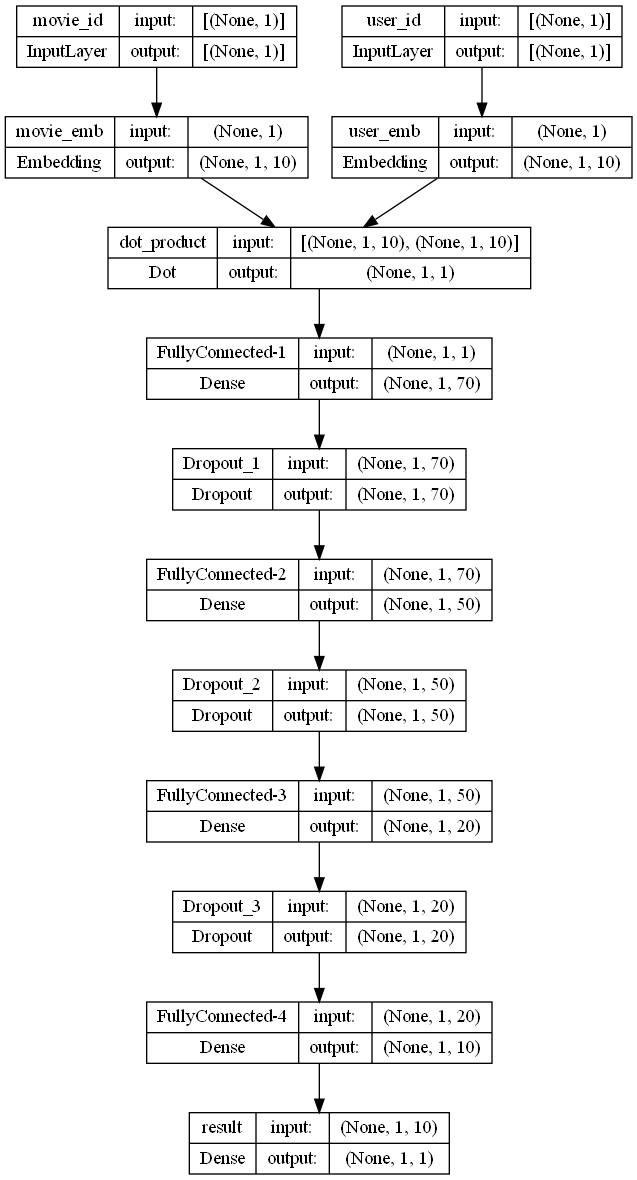

In [255]:
keras.utils.plot_model(model, show_shapes=True) 

In [208]:
# Для подхвата GPU со стороны Keras
tf.debugging.set_log_device_placement(True)

In [257]:
# Обучим модель
history = model.fit(
    [X_train.iloc[:, 0], X_train.iloc[:, 1]],
    y_train,
    batch_size=64,
    epochs=1,
    validation_data=([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test),
)

7797/7797 [==============================] - 68s 9ms/step - loss: 0.8265 - val_loss: 0.8270


In [258]:
# Сформируем эмбеддинги для всех фильмов из нашей выборки
movie_embeddings = movie_model.predict(np.array(np.unique(X_train['movieId'])), batch_size=64) #.reshape(1,-1)[0]
movie_embeddings.shape
MOVIE_EMBEDDING_LIST = movie_embeddings

293/293 [==============================] - 0s 826us/step


In [259]:
# Для примера возьмем рандомный номер из нашей выборки и сформируем эмбеддинг
TEST_USER_ID = 214
user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]

# Создадим KNeighborsClassifier из sklearn
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, [0] * MOVIE_EMBEDDING_LIST.shape[0])

def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices
  
# Получаем рекомендации
recommend_movies(user_embedding)

1/1 [==============================] - 0s 52ms/step


,movie_id
0,648
1,231
2,6996
3,2835
4,7240
5,6916
6,541
7,1482
8,3621
9,1188


In [260]:
user_embeddinds = user_model.predict(X_train['userId'])

15593/15593 [==============================] - 13s 833us/step


In [265]:
len(np.unique(X_train['userId']))

48014

In [262]:
len(np.unique(X_train['userId'][np.sum(user_embeddinds, axis=1) > 0]))

4095

In [267]:
X_test

,userId,movieId
12302813,126040,45442
12475856,127832,1333
25675048,262297,3088
4716593,48404,47
12709929,130148,2266
...,...,...
4366278,44820,2108
10489071,107839,4878
18445001,188114,4896
2745744,28371,8721


In [268]:
y_test

12302813    3.0
12475856    3.0
25675048    3.5
4716593     4.5
12709929    2.0
           ... 
4366278     3.5
10489071    4.0
18445001    4.5
2745744     3.5
1734507     5.0
Name: rating, Length: 213848, dtype: float64